# Applying Machine Learning Models

In [19]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from datetime import datetime

from sklearn import linear_model
# metrics: 計測 → 評価
from sklearn import metrics

from sklearn.model_selection import GridSearchCV
# カーネルなしSVM（SVC: Support Vector Classifierの略）
from sklearn.svm import LinearSVC
# カーネル法を用いたSVM
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier


In [20]:
data1 = pd.read_csv('Data_UCI_not_noise_1.csv')
data2 = pd.read_csv('Data_UCI_not_noise_2.csv')

df_concat = pd.concat([data1, data2])

print(df_concat.shape)

(9233, 642)


In [21]:
features_act = list()
features_uid = list()

with open('act_feature_importance.txt', 'r') as f:
    features_act = f.read().splitlines()

with open('uid_feature_importance.txt', 'r') as f:
    features_uid = f.read().splitlines()

# print(features_act)
# print(features_uid)

In [22]:
from sklearn.model_selection import train_test_split

def split_train_test_data(df, id):
  X = df.drop(['user_Id', 'activity_Id'], axis=1)
  y = df[id]

  return train_test_split(X, y, test_size=0.33, random_state=42) # X_train, X_test, y_train, y_test

  # for i in X_train.columns:
  #   print(X_train[i].dtype)
  # print(X_train.dtypes)

  # # 訓練用
  # X_train = train.drop(['subject', 'Activity', 'ActivityName'], axis=1)
  # y_train = train['subject']

  # # テスト用
  # X_test = test.drop(['subject', 'Activity', 'ActivityName'], axis=1)
  # y_test = test['subject']

  # print('X_train and y_train : ({},{})'.format(X_train.shape, y_train.shape))
  # print('X_test  and y_test  : ({},{})'.format(X_test.shape, y_test.shape))

Let's make a function to plot the confusion matrix

In [23]:
plt.rcParams['font.family'] = 'DejaVu Sans'

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    
    # normalize → 正規化
    if normalize:
        # cmの値は予測結果と実際の値の一致数なので，それを列の合計で割ると確率
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # np.newaxisは次元を追加
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        # plt.text(): 座標（x, y），表示するテキスト，文字位置，色指定
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Let's make a function to run any model specified

In [24]:
# 任意のモデルを実行
def perform_model_epsilon(model, X_train, y_train, X_test, y_test, class_labels, cm_nomalize=True, print_cm=True, cm_cmap=plt.cm.Greens):
    
    # to store results at various phases
    results = dict()
    
    # time at which model starts training 
    train_start_time = datetime.now()
    print('training the model...')
    model.fit(X_train, y_train)
    print('Done')
    train_end_time = datetime.now()
    results['training_time'] = train_end_time - train_start_time
    print('==> training time:- {}\n'.format(results['training_time']))
    
    # predict test data
    print('Predicting test data')
    test_start_time = datetime.now()
    y_pred = model.predict(X_test)
    test_end_time = datetime.now()
    results['testing_time'] = test_end_time - test_start_time
    print('==> testing time:- {}\n'.format(results['testing_time']))
    # 予測結果を格納
    results['predicted'] = y_pred
    
    # calculate overall accuracy of the model
    accuracy = metrics.accuracy_score(y_true=y_test, y_pred=y_pred)
    # store accuracy in results
    results['accuracy'] = accuracy
    print('==> Accuracy:- {}\n'.format(accuracy))
    
    # confusion matrix
    cm = metrics.confusion_matrix(y_test, y_pred)
    results['confusion_matrix'] = cm
    # output confusion matrix
    if print_cm:
        print('\n ********Confusion Matrix********')
        print('\n {}'.format(cm))
    
    # plot confusion matrix
    plt.figure(figsize=(15, 15))
    plt.grid(b=False) # グリッドを非表示
    plot_confusion_matrix(cm, classes=class_labels, normalize=True, title='Normalized Confusion Matrix', cmap = cm_cmap)
    plt.show()
    
    # get classification report
    # print('****************| Classifiction Report |****************')
    # classification_report = metrics.classification_report(y_test, y_pred)
    
    # # store report in results
    # results['classification_report'] = classification_report
    # print(classification_report)
    
    # get f1 score
    f1 = metrics.f1_score(y_test, y_pred, average="macro")
    print("\n F1 Score:{}".format(f1))
    
    # add the trained model to the results
    results['model'] = model
    
    return results, f1
    

Make function to print the gridsearch Parameters

In [25]:
# 同一モデルでの値を表示
def print_grid_search_attributes(model):
    
    # Estimator that gave highest score among all the estimators formed in GridSearch
    print('\n\n==> Best Estimator:')
    print('\t{}\n'.format(model.best_estimator_))
    
    # parameters that gave best results while perfoming grid search
    print('\n==> Best parameters:')
    print('\tParameters of best estimator : {}'.format(model.best_params_))
    
    # number of cross validation splits
    print('\n==> No. of CrossValidation sets:')
    print('\tTotal nmber of cross validation sets: {}'.format(model.n_splits_))
    
    # Average cross validated score of the best estimator, from the Grid Search
    print('\n==> Best Score:')
    print('\tAverage Cross Validate scores of Best estimator : {}'.format(model.best_score_))

In [26]:
labels_act = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING']

labels_uid = list()
for i in range(1, 31):
    labels_uid.append(i)

In [31]:
n_array = [10, 15, 20, 30, 40, 50]
n = n_array[3]
f_add_weighted_noise = set()
for f in features_uid[:n]:
  f_add_weighted_noise.add(f)
print(f_add_weighted_noise)

{'t_grav_acc_max()_Z', 'f_body_gyro_std()_Y', 'f_body_acc_energy()_Z', 't_body_acc_std()_Z', 't_body_gyro_std()_Y', 't_grav_acc_Mag_mean()', 't_grav_acc_max()_X', 'angle6()', 'angle4()', 't_grav_acc_energy()_X', 'f_body_acc_std()_Z', 't_grav_acc_sma()', 't_body_acc_energy()_Z', 'angle5()', 't_grav_acc_max()_Y', 'f_body_gyro_energy()_Y', 't_grav_acc_mean()_Z', 't_grav_acc_mean()_Y', 't_grav_acc_min()_Z', 't_grav_acc_Mag_energy()', 'f_body_gyro_energy()_Z', 't_body_gyro_energy()_Y', 't_body_acc_Corr(Y,Z)', 't_body_gyro_Jerk_Corr(X,Y)', 't_grav_acc_min()_X', 't_grav_acc_Mag_sma()', 't_grav_acc_mean()_X', 't_grav_acc_energy()_Z', 't_grav_acc_min()_Y', 't_grav_acc_energy()_Y'}


In [32]:
weighted_epsilon_array = [0.001, 0.005, 0.008, 0.01, 0.015, 0.02, 0.03, 0.04, 0.05]
weighted_epsilon = weighted_epsilon_array[0]

## 2. Random Forest Classifier

## HAR

--------
epsilon:  1.0
--------
training the model...
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Done
==> training time:- 0:04:07.213992

Predicting test data
==> testing time:- 0:00:00.090015

==> Accuracy:- 0.4706268460781096


 ********Confusion Matrix********

 [[429  46  61   0   4   1]
 [277 147  56   3   5   4]
 [146  39 242   0   1   0]
 [  0   0   0  66 225 215]
 [  2   0   0  67 301 163]
 [  0   1   0  68 229 249]]


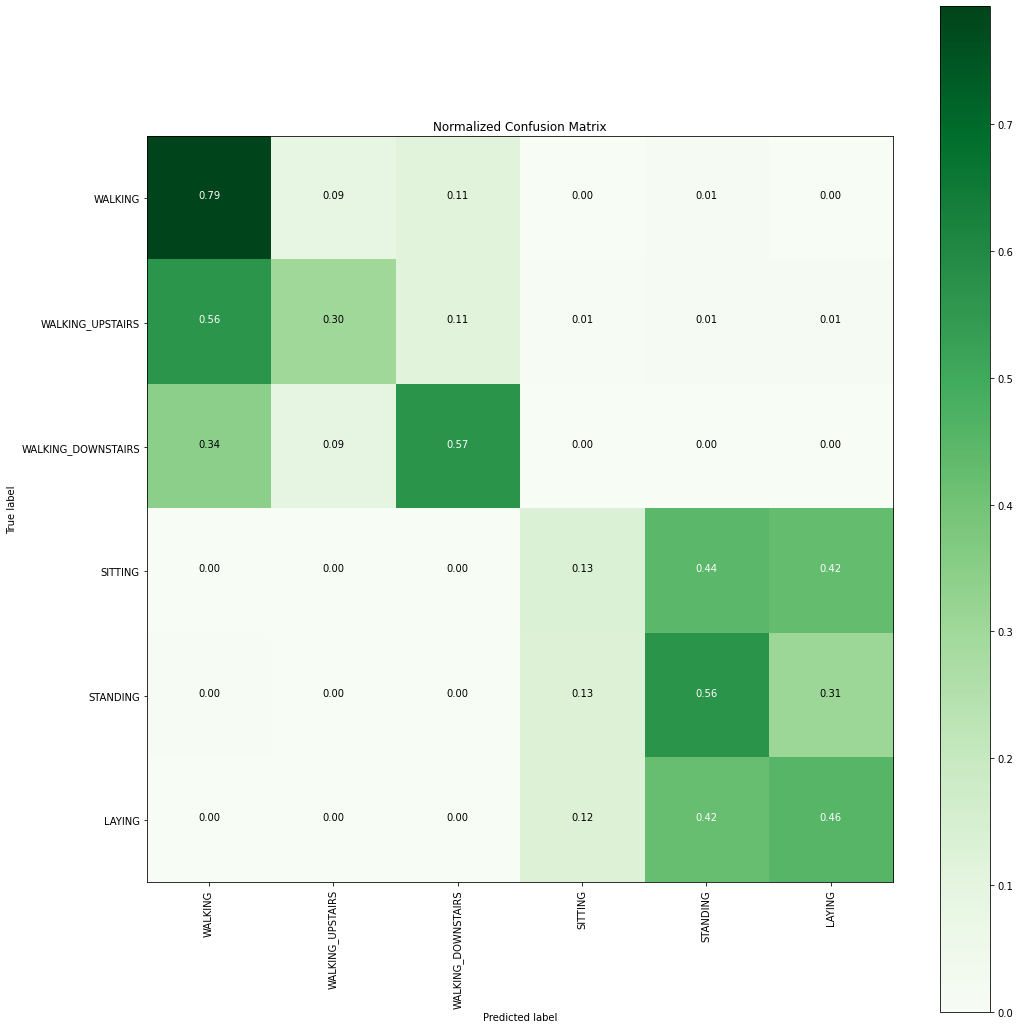


 F1 Score:0.4512770748142367


==> Best Estimator:
	RandomForestClassifier(max_depth=10, n_estimators=180)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 10, 'n_estimators': 180}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.4818958525694688
--------
epsilon:  1.1
--------
training the model...
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Done
==> training time:- 0:04:16.612277

Predicting test data
==> testing time:- 0:00:00.079950

==> Accuracy:- 0.502461437479488


 ********Confusion Matrix********

 [[463  25  49   0   2   2]
 [292 138  52   0   8   2]
 [142  18 267   0   1   0]
 [  1   0   0  24 275 206]
 [  0   1   0  34 331 167]
 [  0   0   0  33 206 308]]


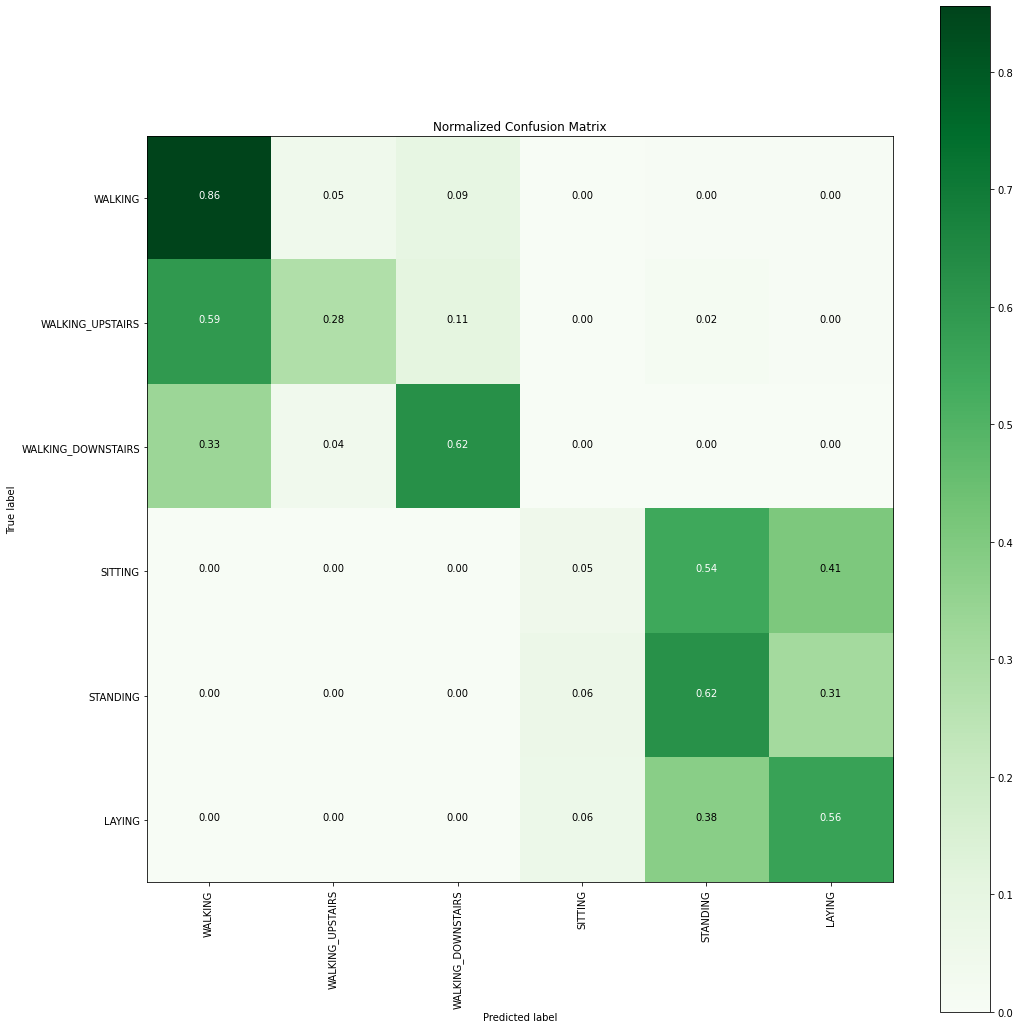


 F1 Score:0.46540914209726253


==> Best Estimator:
	RandomForestClassifier(max_depth=8, n_estimators=200)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 8, 'n_estimators': 200}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.5082451028662549
--------
epsilon:  1.2
--------
training the model...
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Done
==> training time:- 0:04:08.900444

Predicting test data
==> testing time:- 0:00:00.080937

==> Accuracy:- 0.5126353790613718


 ********Confusion Matrix********

 [[447  37  55   0   1   1]
 [265 161  52   3   7   4]
 [141  28 259   0   0   0]
 [  0   0   0  36 234 236]
 [  0   0   0  23 346 164]
 [  0   0   0  33 201 313]]


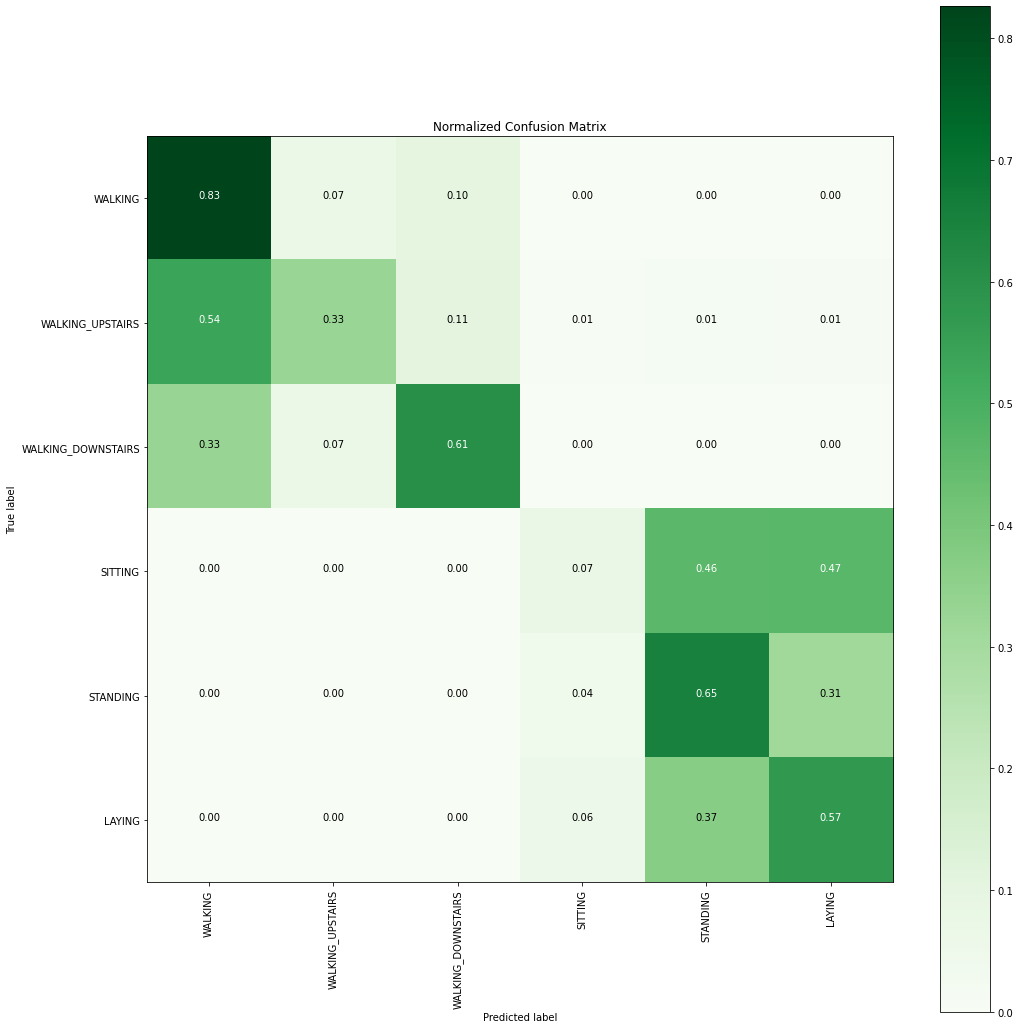


 F1 Score:0.4800486947265579


==> Best Estimator:
	RandomForestClassifier(max_depth=8, n_estimators=180)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 8, 'n_estimators': 180}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.5260235365409305
--------
epsilon:  1.3
--------
training the model...
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Done
==> training time:- 0:04:13.029619

Predicting test data
==> testing time:- 0:00:00.070915

==> Accuracy:- 0.5352806038726616


 ********Confusion Matrix********

 [[448  44  47   0   2   0]
 [244 197  48   0   3   0]
 [112  33 282   0   1   0]
 [  0   0   0  22 278 206]
 [  0   0   0  19 365 149]
 [  0   0   0  38 192 317]]


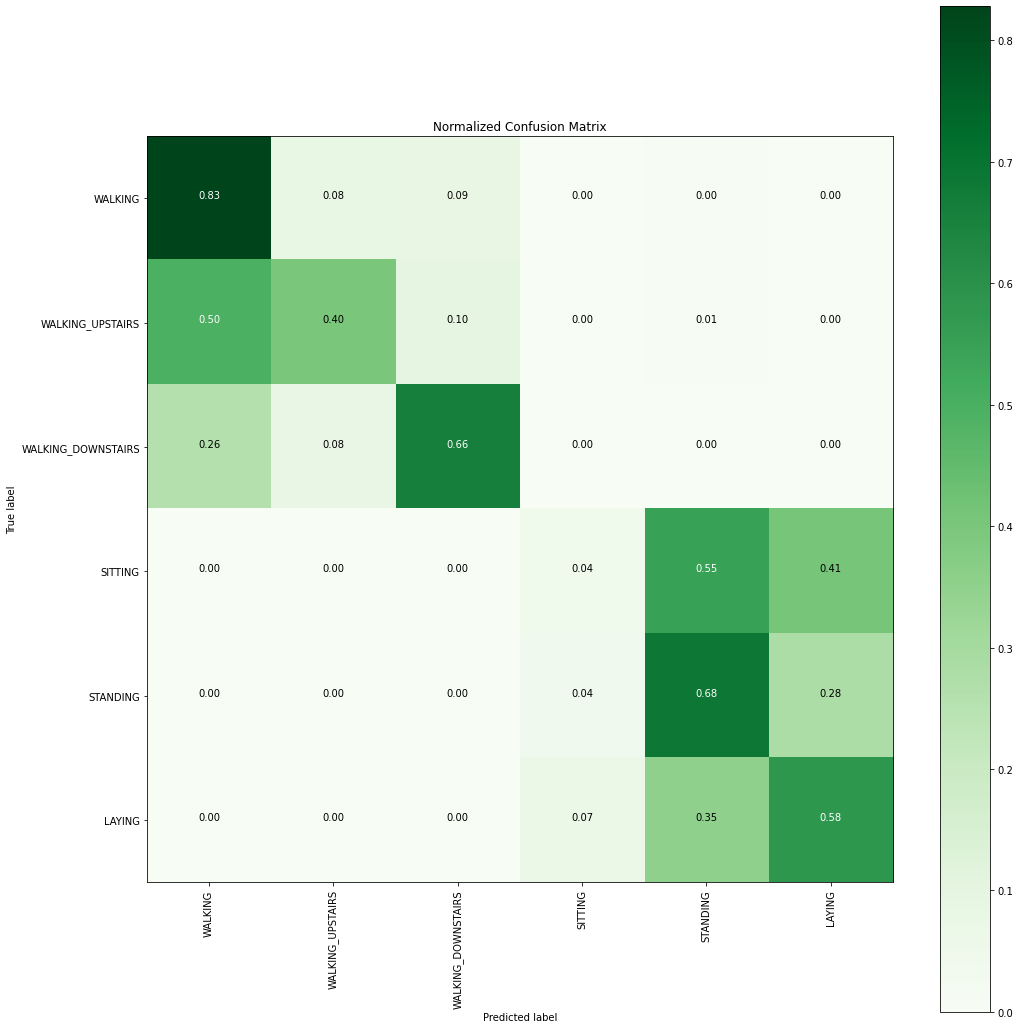


 F1 Score:0.5012933398720378


==> Best Estimator:
	RandomForestClassifier(max_depth=8, n_estimators=180)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 8, 'n_estimators': 180}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.5468813626170983
--------
epsilon:  1.4
--------
training the model...
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Done
==> training time:- 0:04:20.689976

Predicting test data
==> testing time:- 0:00:00.085494

==> Accuracy:- 0.5615359369872005


 ********Confusion Matrix********

 [[465  31  44   0   1   0]
 [256 181  52   0   2   1]
 [113  22 293   0   0   0]
 [  0   0   0  23 260 223]
 [  0   0   0  15 397 121]
 [  0   0   0  29 166 352]]


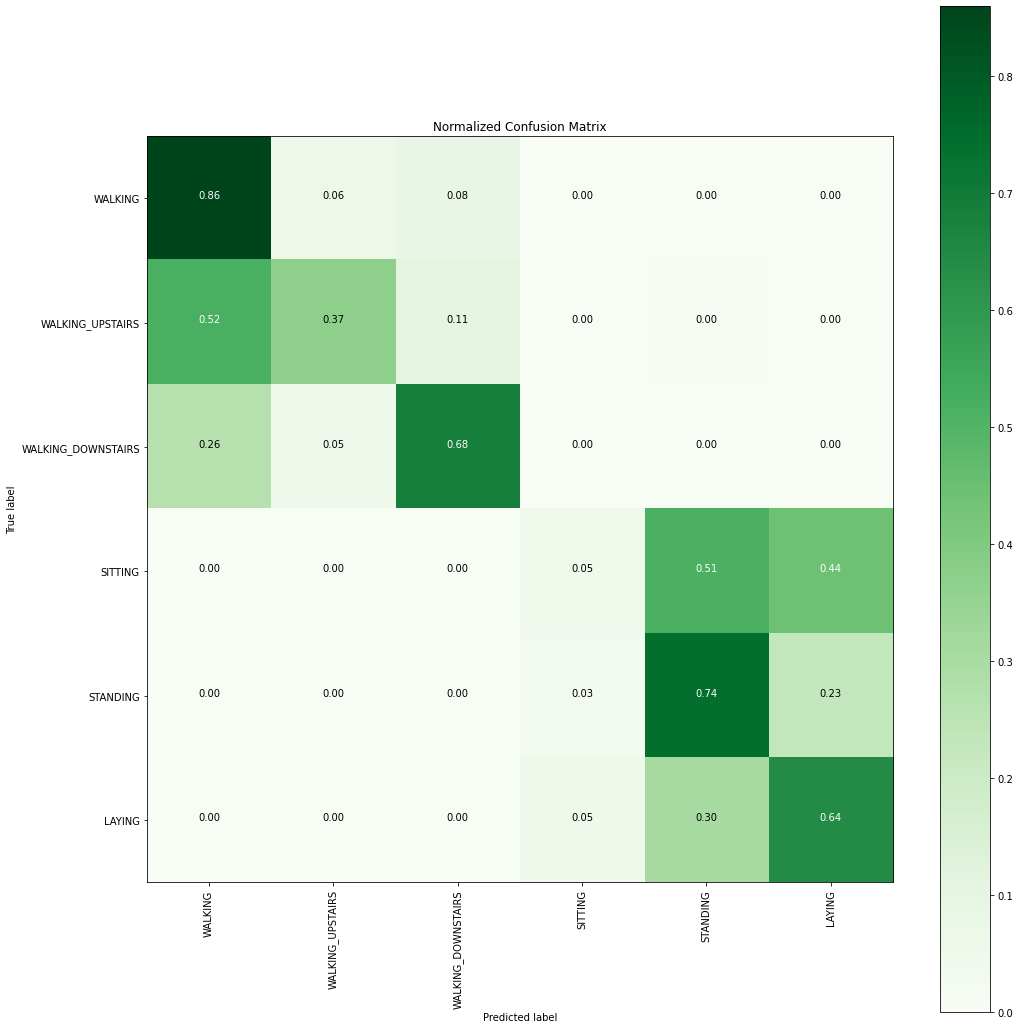


 F1 Score:0.5204488743257042


==> Best Estimator:
	RandomForestClassifier(max_depth=8, n_estimators=200)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 8, 'n_estimators': 200}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.5701580116572613
--------
epsilon:  1.5
--------
training the model...
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Done
==> training time:- 0:04:38.399732

Predicting test data
==> testing time:- 0:00:00.080429

==> Accuracy:- 0.568427961929767


 ********Confusion Matrix********

 [[473  23  45   0   0   0]
 [243 202  44   0   2   1]
 [107  33 288   0   0   0]
 [  0   0   0  29 241 236]
 [  0   0   0  15 393 125]
 [  0   0   0  18 182 347]]


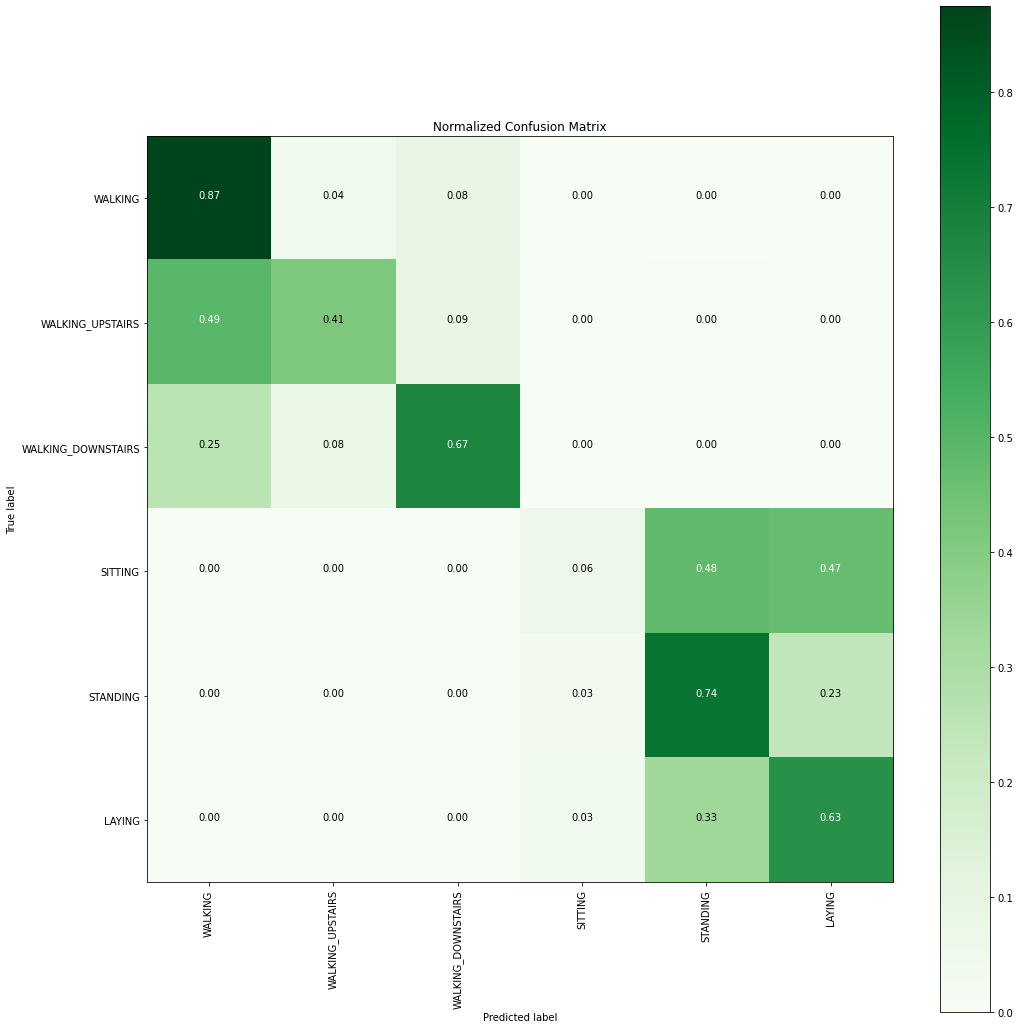


 F1 Score:0.5306991194266774


==> Best Estimator:
	RandomForestClassifier(max_depth=8, n_estimators=200)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 8, 'n_estimators': 200}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.5766220061825538
--------
epsilon:  1.8
--------
training the model...
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Done
==> training time:- 0:05:22.314540

Predicting test data
==> testing time:- 0:00:00.102563

==> Accuracy:- 0.608139153265507


 ********Confusion Matrix********

 [[466  35  40   0   0   0]
 [178 271  43   0   0   0]
 [103  35 290   0   0   0]
 [  0   0   0  29 250 227]
 [  0   0   0  12 424  97]
 [  0   0   0  22 152 373]]


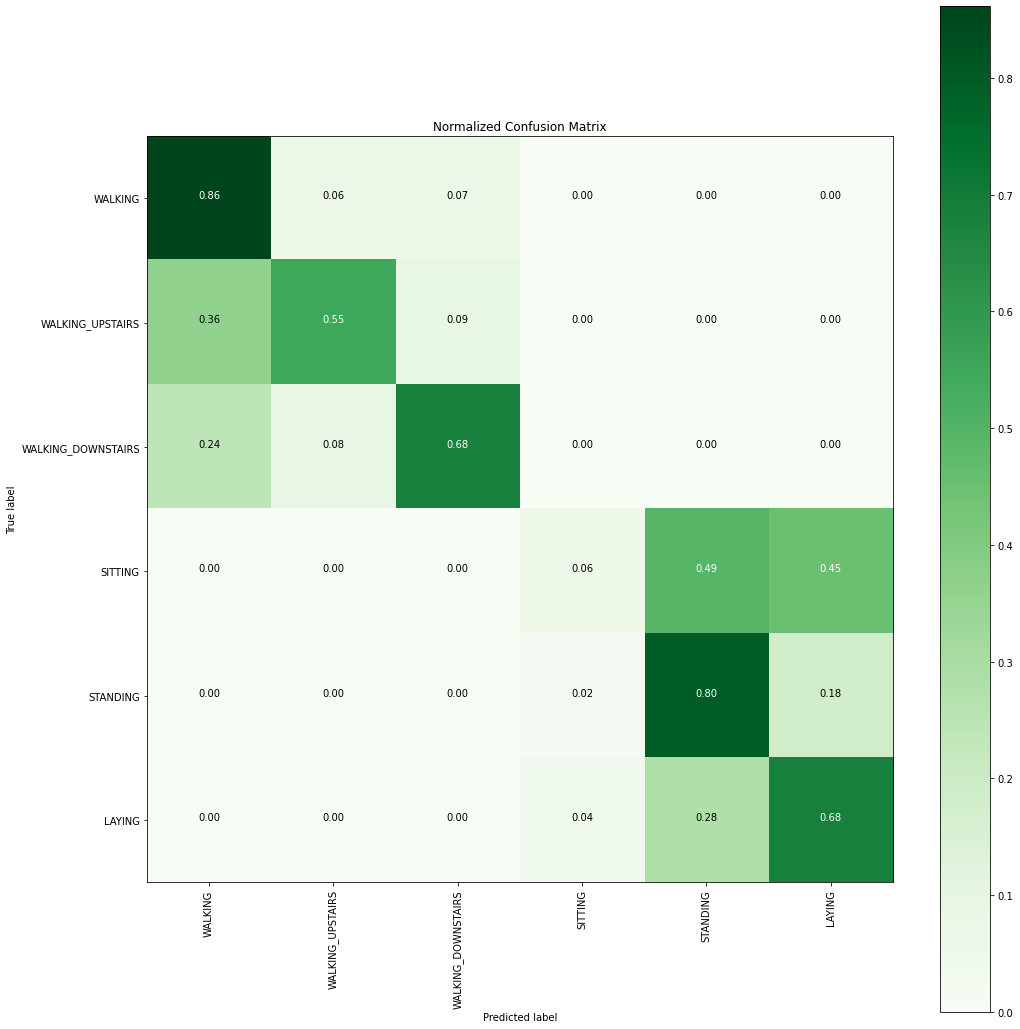


 F1 Score:0.5706595882289224


==> Best Estimator:
	RandomForestClassifier(max_depth=8, n_estimators=160)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 8, 'n_estimators': 160}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.6215642357415343
--------
epsilon:  2.0
--------
training the model...
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Done
==> training time:- 0:05:29.298749

Predicting test data
==> testing time:- 0:00:00.187565

==> Accuracy:- 0.6334099113882508


 ********Confusion Matrix********

 [[482  27  31   0   1   0]
 [140 299  52   0   0   1]
 [102  37 289   0   0   0]
 [  0   0   0  34 247 225]
 [  0   0   0  18 417  98]
 [  0   0   0  17 121 409]]


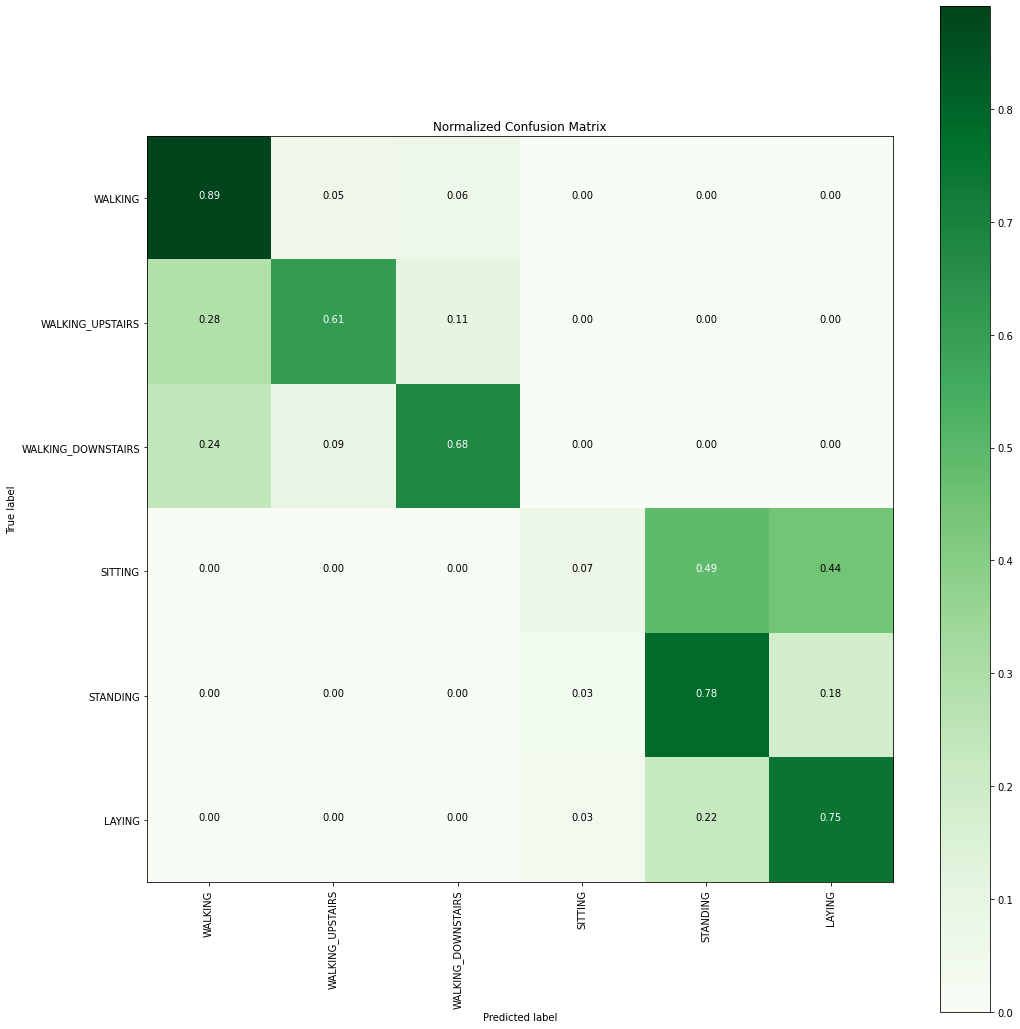


 F1 Score:0.595598517509423


==> Best Estimator:
	RandomForestClassifier(max_depth=8, n_estimators=180)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 8, 'n_estimators': 180}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.642740592631869
--------
epsilon:  2.2
--------
training the model...
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Done
==> training time:- 0:28:34.074583

Predicting test data
==> testing time:- 0:00:00.251288

==> Accuracy:- 0.6563833278634723


 ********Confusion Matrix********

 [[478  34  29   0   0   0]
 [118 330  44   0   0   0]
 [ 68  49 311   0   0   0]
 [  0   0   0  72 221 213]
 [  0   0   0  38 409  86]
 [  0   0   0  34 113 400]]


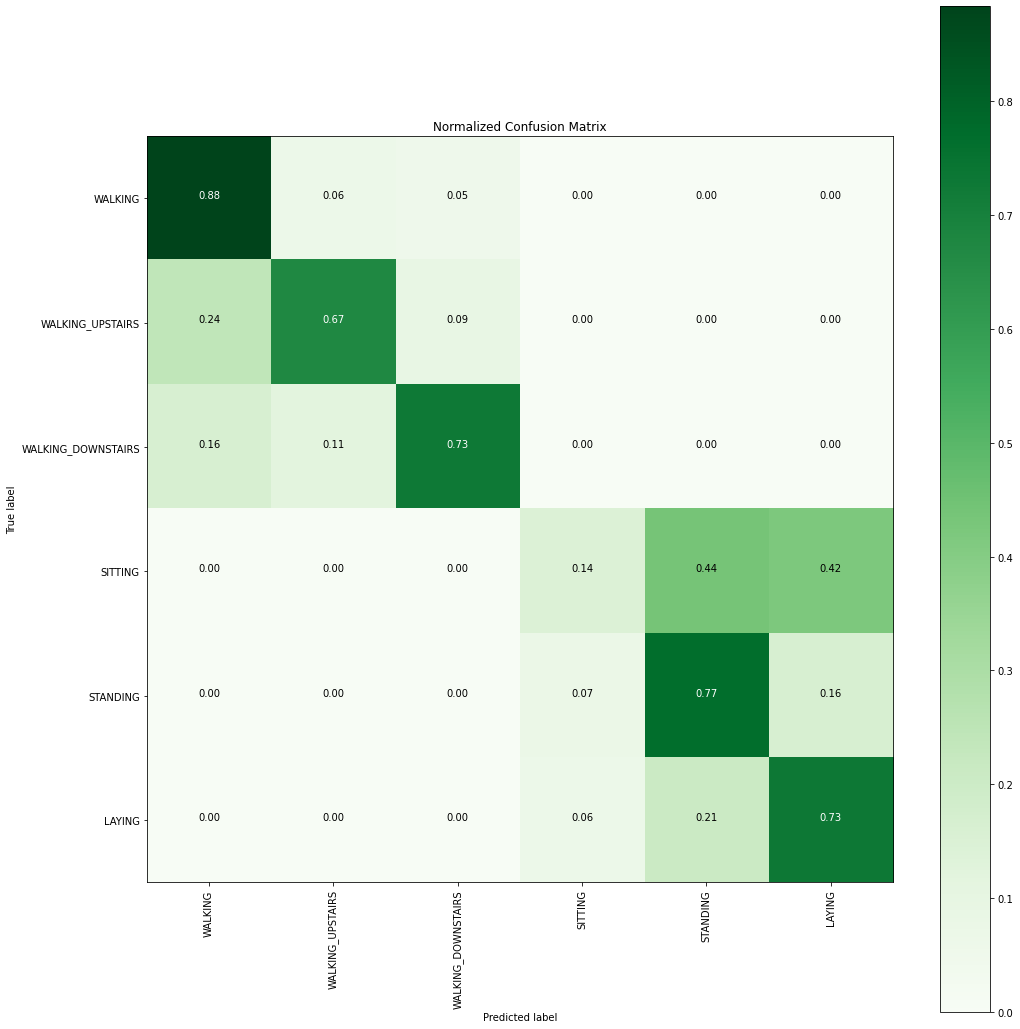


 F1 Score:0.6322185804869136


==> Best Estimator:
	RandomForestClassifier(max_depth=10, n_estimators=200)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 10, 'n_estimators': 200}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.656642588575466
--------
epsilon:  2.5
--------
training the model...
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Done
==> training time:- 0:04:38.671934

Predicting test data
==> testing time:- 0:00:00.135823

==> Accuracy:- 0.6668854611092878


 ********Confusion Matrix********

 [[478  33  30   0   0   0]
 [ 94 353  45   0   0   0]
 [ 65  54 309   0   0   0]
 [  0   0   0  99 191 216]
 [  0   0   0  48 396  89]
 [  0   0   0  54  96 397]]


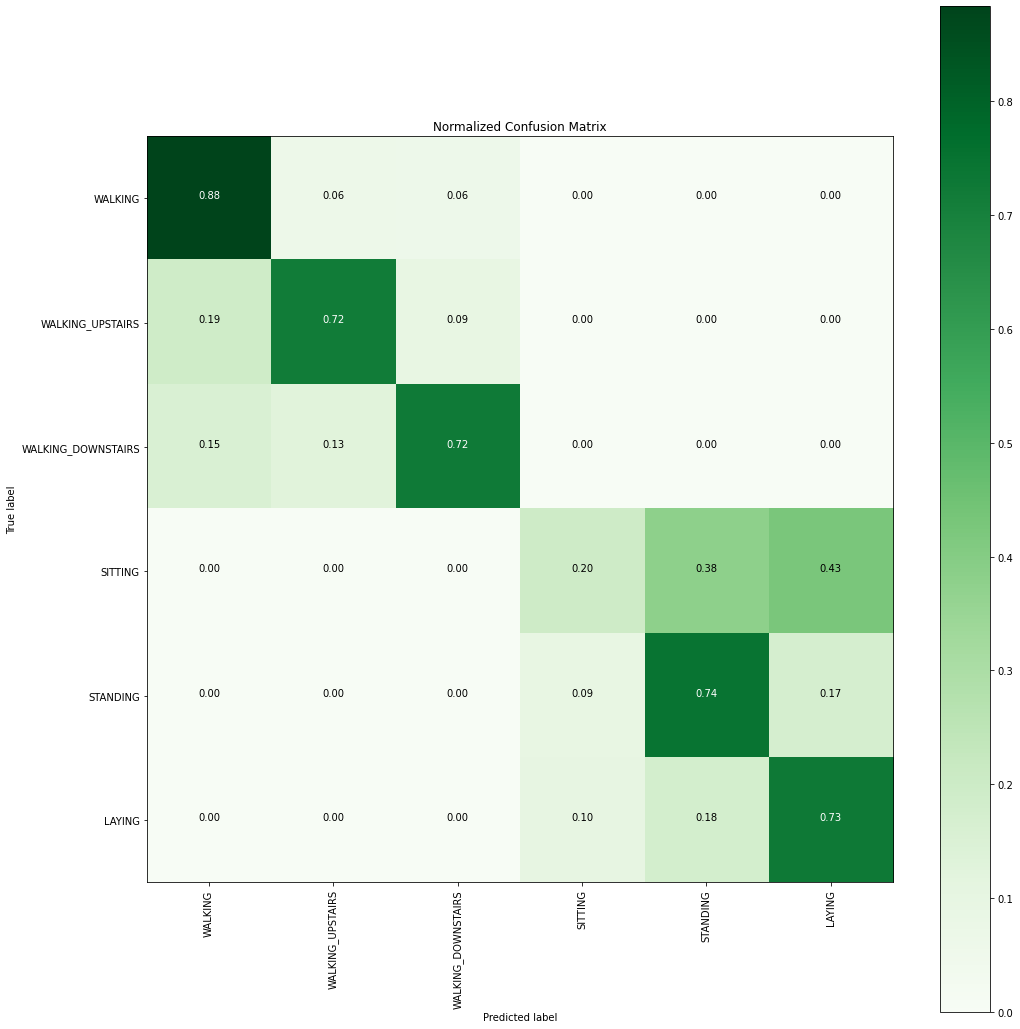


 F1 Score:0.6495367330634302


==> Best Estimator:
	RandomForestClassifier(max_depth=12, n_estimators=140)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 12, 'n_estimators': 140}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.6838050784703729


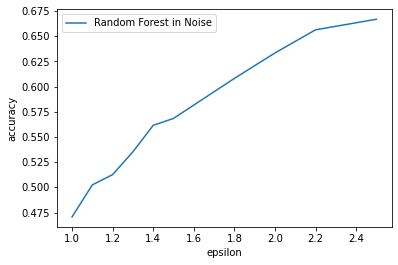

In [33]:
import warnings
# 収束しなかった場合のwarning
from sklearn.exceptions import ConvergenceWarning
# warningを無視する
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=ConvergenceWarning)

# epsilons = [0.01, 0.05, 0.1, 0.3, 0.5, 1.0, 1.5, 2.0, 2.5, 3, 4, 5]
acc_array_random_har = list()


epsilons = [1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.8, 2.0, 2.2, 2.5]

for epsilon in epsilons:

  print('--------')
  print('epsilon:  '+ str(epsilon))
  print('--------')

  X_train, X_test, y_train, y_test = split_train_test_data(df_concat, 'activity_Id')

  for feature in f_add_weighted_noise:
    X_train[feature] = X_train[feature].apply(lambda x: x + np.random.laplace(0, 1.0/weighted_epsilon))
    X_test[feature] = X_test[feature].apply(lambda x: x + np.random.laplace(0, 1.0/weighted_epsilon))

  for col in X_train:
      # default sensitivity = 1.0
    if col not in f_add_weighted_noise:
      X_train[col] = X_train[col].apply(lambda x: x + np.random.laplace(0, 1.0/epsilon))
      X_test[col] = X_test[col].apply(lambda x: x + np.random.laplace(0, 1.0/epsilon))
    
  params = {'n_estimators': np.arange(120,201,20), 'max_depth':np.arange(6,15,2)}
  rfc = RandomForestClassifier()
  rfc_grid = GridSearchCV(rfc, param_grid=params, cv=5, verbose=1, n_jobs=-1)
  rfc_grid_results, f1 = perform_model_epsilon(rfc_grid, X_train.values, y_train.values, X_test.values, y_test.values, class_labels=labels_act)
  acc_array_random_har.append(rfc_grid_results['accuracy'])
  
  # observe the attributes of the model 
  print_grid_search_attributes(rfc_grid_results['model'])
    
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(epsilons[::-1], acc_array_random_har[::-1], label='Random Forest in Noise')
ax.set_xlabel('epsilon')
ax.set_ylabel('accuracy')
plt.legend(loc='best')
plt.show()


## UID

--------
epsilon:  1.0
--------
training the model...
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Done
==> training time:- 0:06:34.341113

Predicting test data
==> testing time:- 0:00:00.086979

==> Accuracy:- 0.05054151624548736


 ********Confusion Matrix********

 [[10  0  1  1  0  0  0  2  0  0  0  0  1  0  1  4  4  9  0  0 11  0  2 15
  15 26  3  4  6  5]
 [ 3  1  1  0  0  0  1  1  1  0  0  0  2  0  0  6  4  7  0  1  8  1  1 11
  17 21  6  1  3  6]
 [ 3  0  2  0  0  0  0  0  0  0  1  0  2  1  0  2  2  4  1  1  9  0  2 14
  17 22  5  0  2  5]
 [ 5  0  0  0  0  0  0  0  0  0  1  0  3  1  1  2  4  7  0  2  8  1  0 11
  18 14  4  0  6  4]
 [ 4  0  0  0  0  0  2  0  0  1  0  0  2  0  2  3  4  5  0  0  9  1  0 12
  14 16  5  2  5  2]
 [ 4  0  1  0  0  1  2  1  0  0  0  1  3  2  0  3  2  5  0  1 12  0  2  8
  11 18  4  0  5  2]
 [ 2  1  1  0  0  0  1  2  0  0  0  0  0  0  0  4  7  2  0  0  8  0  2  9
  13 15  5  1  5  5]
 [ 3  0  2  1  0  0  0  1  0  1  1  0  3  0  0  3

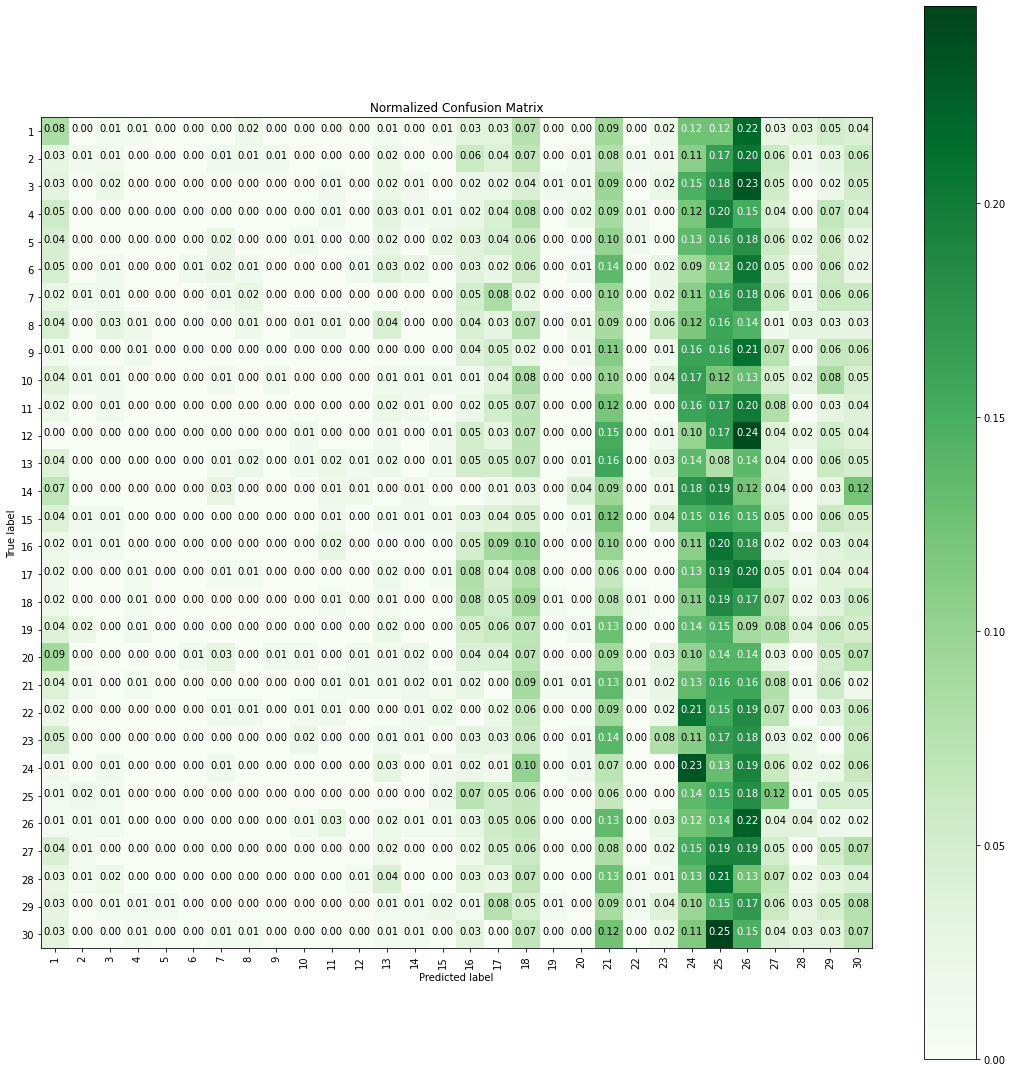


 F1 Score:0.03394248035697534


==> Best Estimator:
	RandomForestClassifier(max_depth=14, n_estimators=160)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 14, 'n_estimators': 160}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.056259019489279784
--------
epsilon:  1.1
--------
training the model...
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Done
==> training time:- 0:06:38.727071

Predicting test data
==> testing time:- 0:00:00.093443

==> Accuracy:- 0.058089924515917296


 ********Confusion Matrix********

 [[17  0  1  0  0  0  0  0  0  0  0  0  1  2  1  4  3  8  0  0 14  0  4 13
  15 16  6  0  3 12]
 [ 2  0  0  1  0  0  0  0  0  1  1  0  0  0  0  1  6  6  0  0 14  0  1 14
  12 30  4  0  6  4]
 [ 2  0  0  0  0  0  0  0  0  0  0  0  3  0  0  3  3  7  0  0 12  0  0 12
  15 31  2  0  2  3]
 [ 1  0  0  0  0  0  0  1  0  0  0  0  1  0  0  3  2  9  0  0

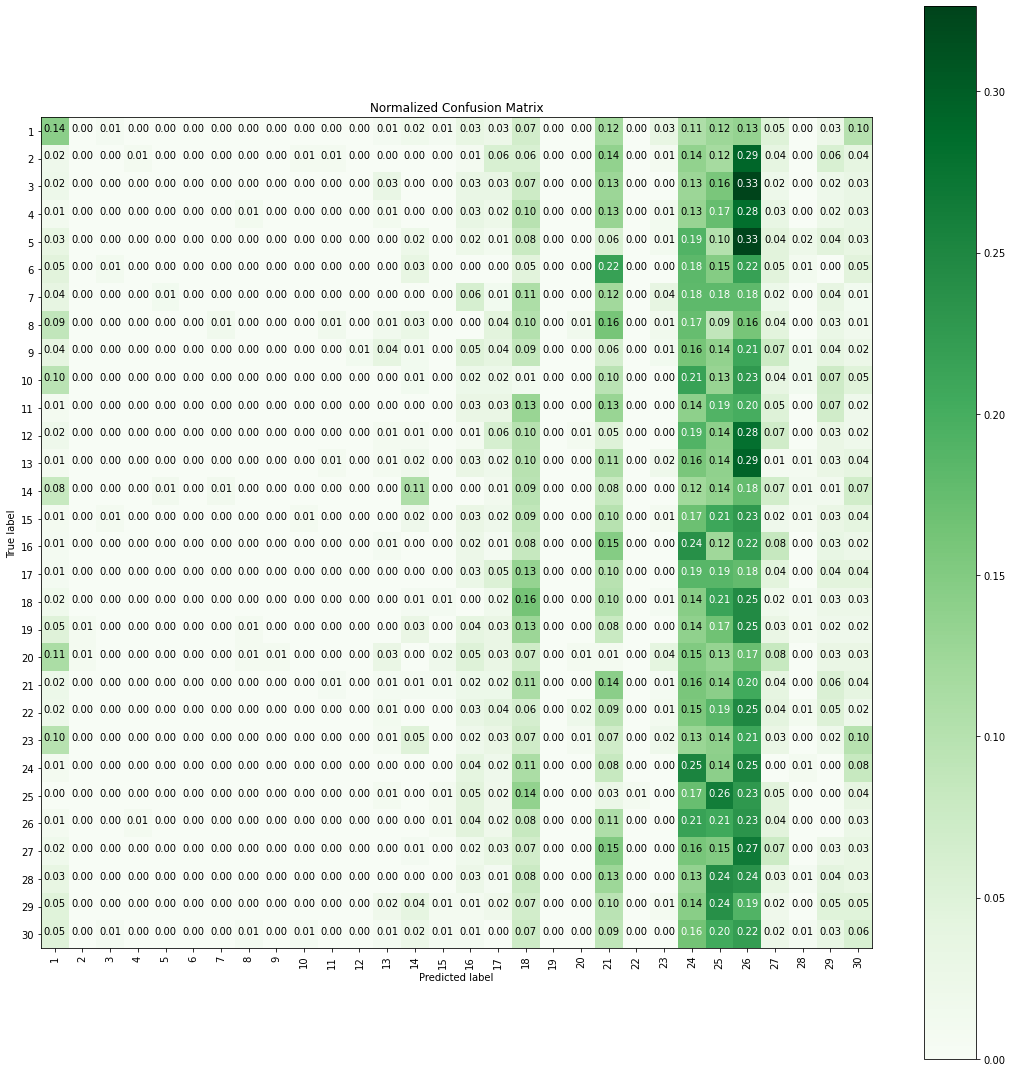


 F1 Score:0.03532567885831885


==> Best Estimator:
	RandomForestClassifier(max_depth=10, n_estimators=200)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 10, 'n_estimators': 200}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.05755064300388009
--------
epsilon:  1.2
--------
training the model...
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Done
==> training time:- 0:06:48.735066

Predicting test data
==> testing time:- 0:00:00.085564

==> Accuracy:- 0.05940269117164424


 ********Confusion Matrix********

 [[17  0  0  0  0  0  1  0  0  1  2  1  2  1  0  4  2 13  1  3 10  0  3 17
  15 13  3  2  5  4]
 [ 6  0  0  0  0  0  0  0  0  0  0  0  1  0  0  4  1  7  0  0 10  0  1 18
  19 20  9  0  3  4]
 [ 3  0  0  0  0  0  0  0  0  0  1  0  1  0  1  3  3 13  0  0  8  0  0 14
  19 20  6  0  1  2]
 [ 1  0  1  0  1  0  0  0  0  0  0  0  1  0  0  4  7  8  1  0  

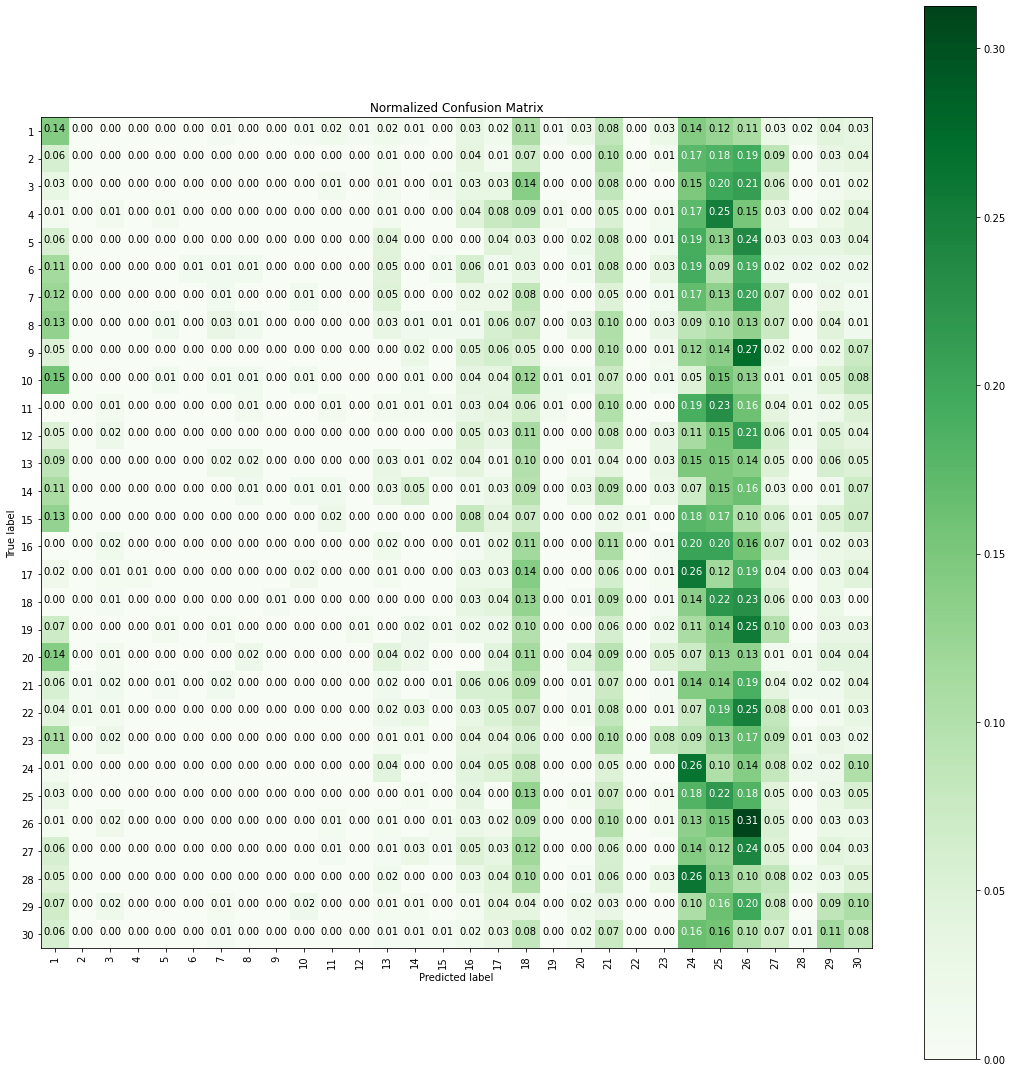


 F1 Score:0.03961549033612759


==> Best Estimator:
	RandomForestClassifier(max_depth=12, n_estimators=200)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 12, 'n_estimators': 200}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.0662790925463267
--------
epsilon:  1.3
--------
training the model...
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Done
==> training time:- 0:06:49.424617

Predicting test data
==> testing time:- 0:00:00.152206

==> Accuracy:- 0.058089924515917296


 ********Confusion Matrix********

 [[21  1  2  0  0  0  0  0  0  0  0  1  1  4  0  0  0 13  0  5  9  0  3 11
  14 19  6  2  3  5]
 [13  0  0  0  1  0  0  0  0  1  1  0  2  0  1  2  2  5  0  0 10  0  3 16
  12 19  7  0  7  1]
 [ 3  1  0  0  0  0  1  0  0  1  0  0  0  1  1  5  3  6  0  1 10  1  2 14
  13 17  4  0  8  3]
 [ 1  1  1  1  0  0  0  0  0  0  0  0  0  0  0  4  3  9  0  1 1

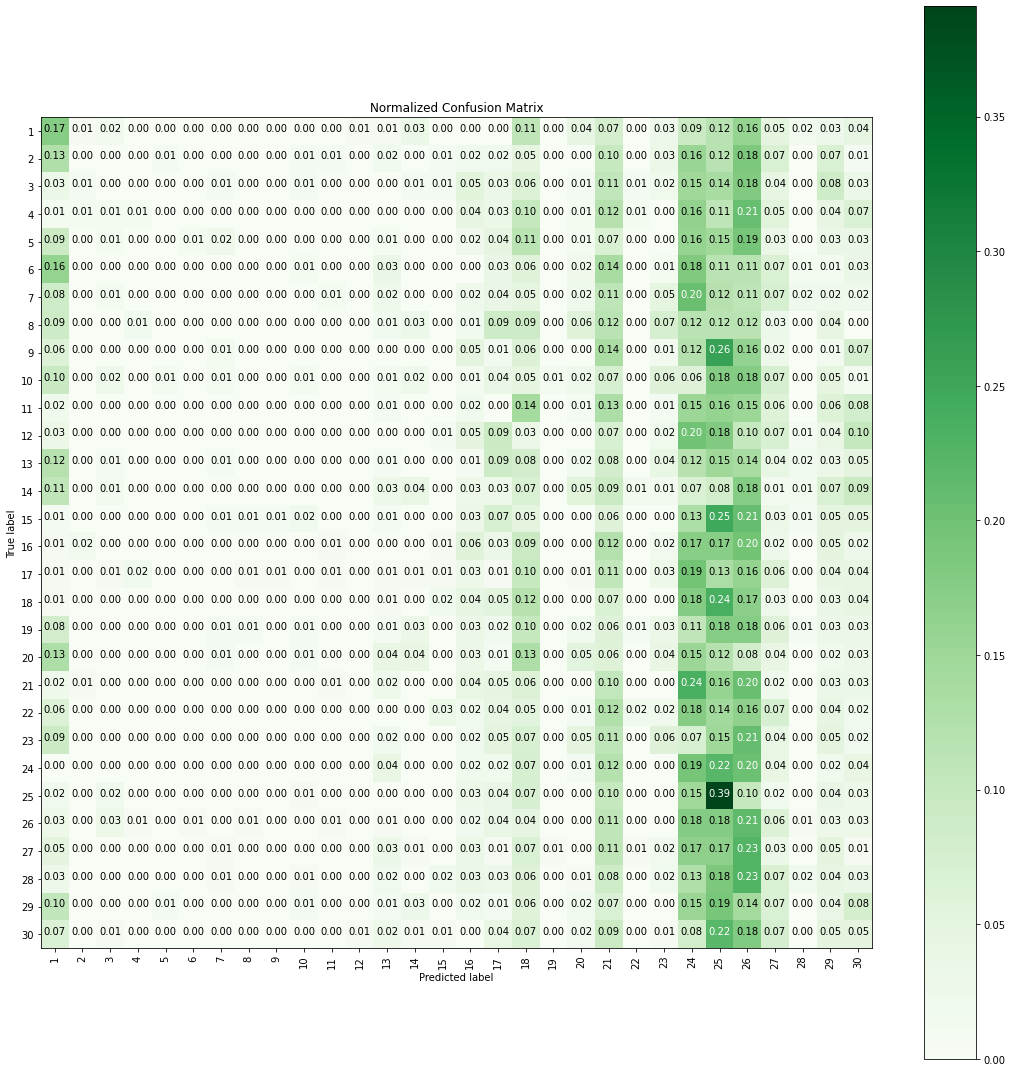


 F1 Score:0.03611960984713885


==> Best Estimator:
	RandomForestClassifier(max_depth=10, n_estimators=160)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 10, 'n_estimators': 160}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.06692503490256665
--------
epsilon:  1.4
--------
training the model...
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Done
==> training time:- 0:06:59.923736

Predicting test data
==> testing time:- 0:00:00.094360

==> Accuracy:- 0.07745323268788973


 ********Confusion Matrix********

 [[26  1  0  0  1  1  0  0  0  0  0  0  2  3  1  4  3  6  0  2  9  0  1  6
  19 14 10  0  4  7]
 [ 3  0  1  0  0  2  1  0  1  0  1  0  1  2  0  5  4  9  0  0  7  0  1 15
  11 18  8  2  8  3]
 [ 1  0  0  0  1  1  1  1  0  1  1  0  2  0  0  2  4 10  0  0 11  0  2 15
  12 15  8  0  5  2]
 [ 1  0  1  2  0  0  0  0  0  0  2  0  0  1  0  4  3  8  0  0  

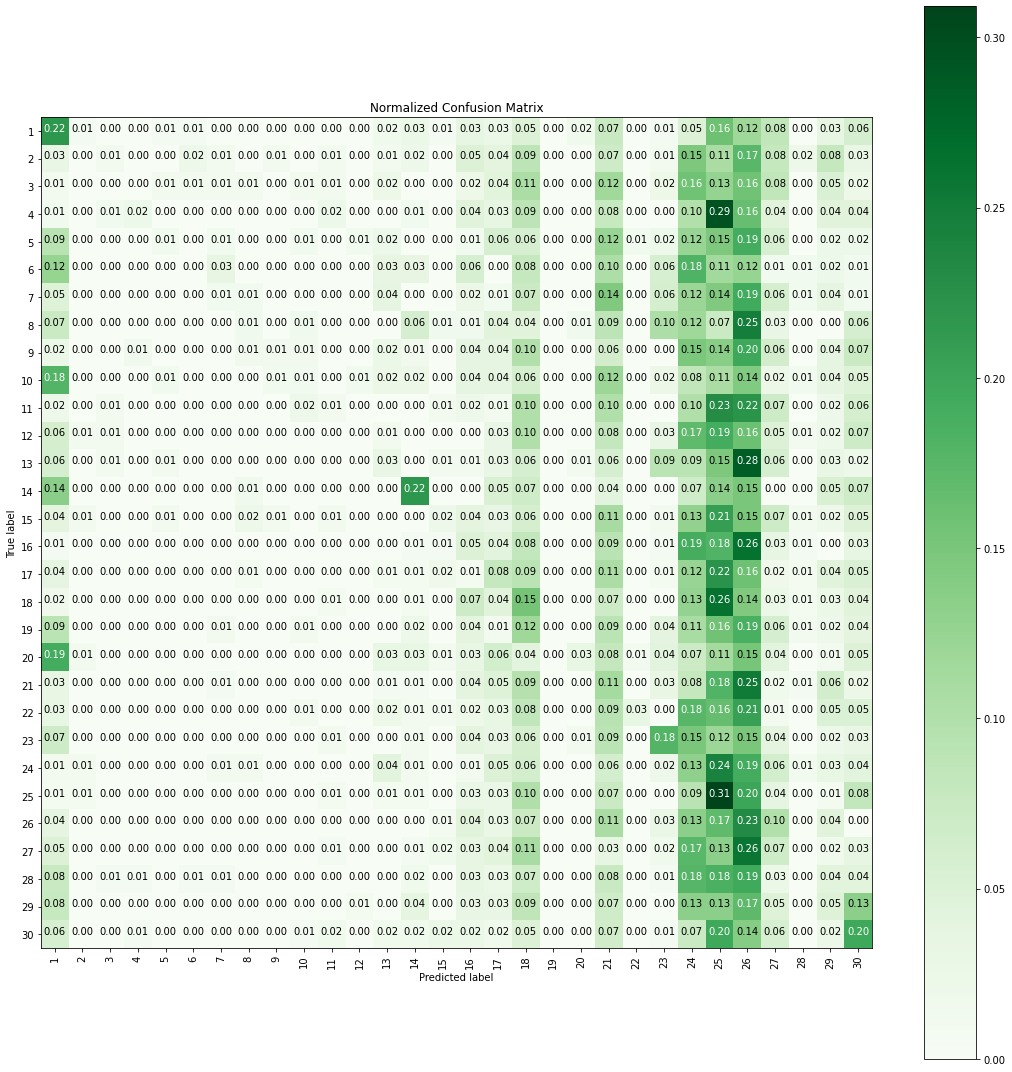


 F1 Score:0.060484473984546955


==> Best Estimator:
	RandomForestClassifier(max_depth=10, n_estimators=180)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 10, 'n_estimators': 180}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.07613918190212132
--------
epsilon:  1.5
--------
training the model...
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Done
==> training time:- 0:07:03.335753

Predicting test data
==> testing time:- 0:00:00.088587

==> Accuracy:- 0.0781096160157532


 ********Confusion Matrix********

 [[38  0  0  0  0  0  0  1  0  0  0  0  0  3  0  1  3  6  0  1  6  0  2 11
  16 18  6  0  2  6]
 [ 6  1  0  0  0  0  0  1  0  1  0  0  0  1  1  5  5  4  0  0  7  0  3 14
  14 28  4  0  5  3]
 [ 5  0  0  0  0  0  0  0  0  0  0  0  1  0  0  1  5  6  0  0  9  0  0 17
  17 24  2  0  6  2]
 [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0  4  0  0  

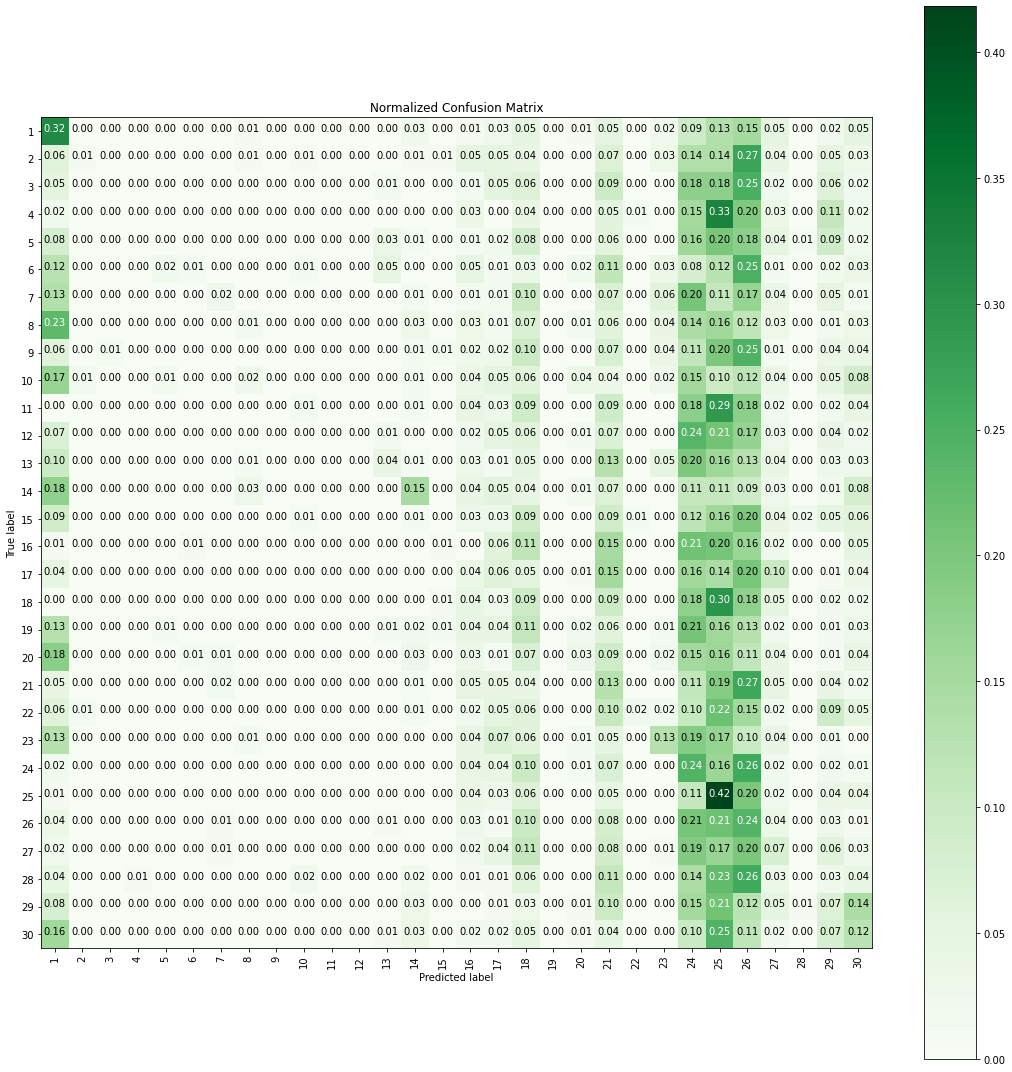


 F1 Score:0.05394160613303171


==> Best Estimator:
	RandomForestClassifier(max_depth=8, n_estimators=200)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 8, 'n_estimators': 200}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.08309148586331777
--------
epsilon:  1.8
--------
training the model...
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Done
==> training time:- 0:07:04.826148

Predicting test data
==> testing time:- 0:00:00.068719

==> Accuracy:- 0.09747292418772563


 ********Confusion Matrix********

 [[48  0  0  0  0  0  0  1  0  1  0  0  0  1  0  1  3  6  0  0  3  0  1  7
  22 14  6  0  2  4]
 [11  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  6  3  0  0  6  0  0 12
  18 36  1  0  6  2]
 [ 7  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  5  0  0  2  0  0 15
  26 30  4  0  1  3]
 [ 3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  8  0  0  3 

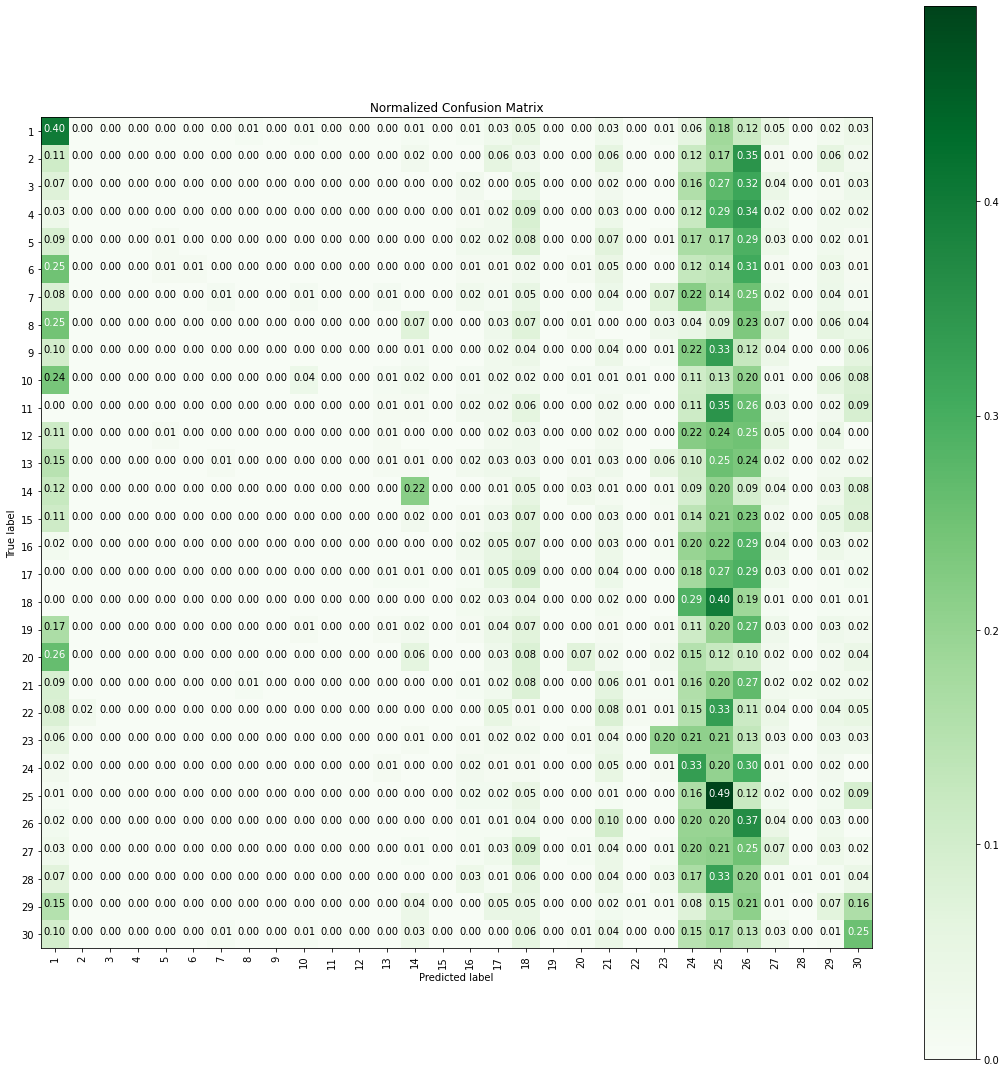


 F1 Score:0.06668444424289884


==> Best Estimator:
	RandomForestClassifier(max_depth=6, n_estimators=200)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 6, 'n_estimators': 200}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.09747774267568496
--------
epsilon:  2.0
--------
training the model...
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Done
==> training time:- 0:07:27.752917

Predicting test data
==> testing time:- 0:00:00.071520

==> Accuracy:- 0.10797505743354119


 ********Confusion Matrix********

 [[43  0  0  0  1  0  0  1  0  0  0  0  1  4  0  4  5  9  0  2  3  0  3  5
   7 12  4  1  8  7]
 [10  1  0  0  0  1  1  0  0  0  0  0  1  2  1  4  6  5  0  0  5  3  0 14
   9 25  6  0  5  4]
 [ 3  0  0  0  0  0  0  0  0  0  0  0  3  0  1  3  3  9  0  1  5  1  1 17
  11 24  5  0  4  4]
 [ 0  1  0  0  0  0  0  0  0  0  0  0  0  0  1  2  2  7  0  0  5 

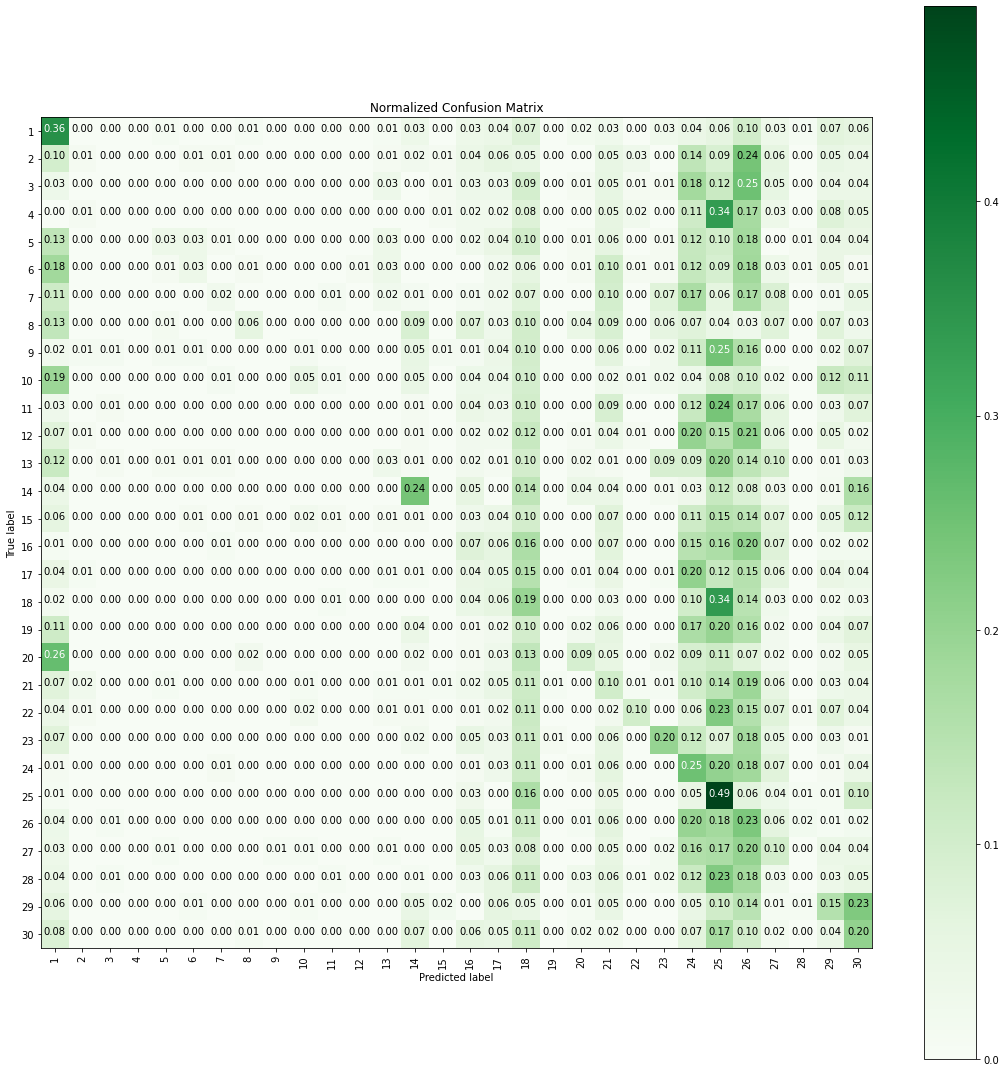


 F1 Score:0.08497974575299286


==> Best Estimator:
	RandomForestClassifier(max_depth=8, n_estimators=160)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 8, 'n_estimators': 160}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.10976501332762181
--------
epsilon:  2.2
--------
training the model...
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Done
==> training time:- 0:07:08.608023

Predicting test data
==> testing time:- 0:00:00.096893

==> Accuracy:- 0.12011814899901542


 ********Confusion Matrix********

 [[40  0  1  0  0  1  2  0  0  0  0  0  1  3  0  3  4  6  0  1  6  0  5  5
   5 10 13  0  5  9]
 [ 4  8  3  0  0  0  0  2  0  1  0  0  4  1  2  4  4  8  0  1  4  4  1 13
   7 14  9  0  8  1]
 [ 2  0  2  0  0  1  2  0  0  1  1  2  0  0  0  0  2 11  0  0  7  1  0 16
  17 15  6  2  4  3]
 [ 2  1  2  0  0  0  0  0  1  0  2  0  1  0  0  3  4  7  0  0  4 

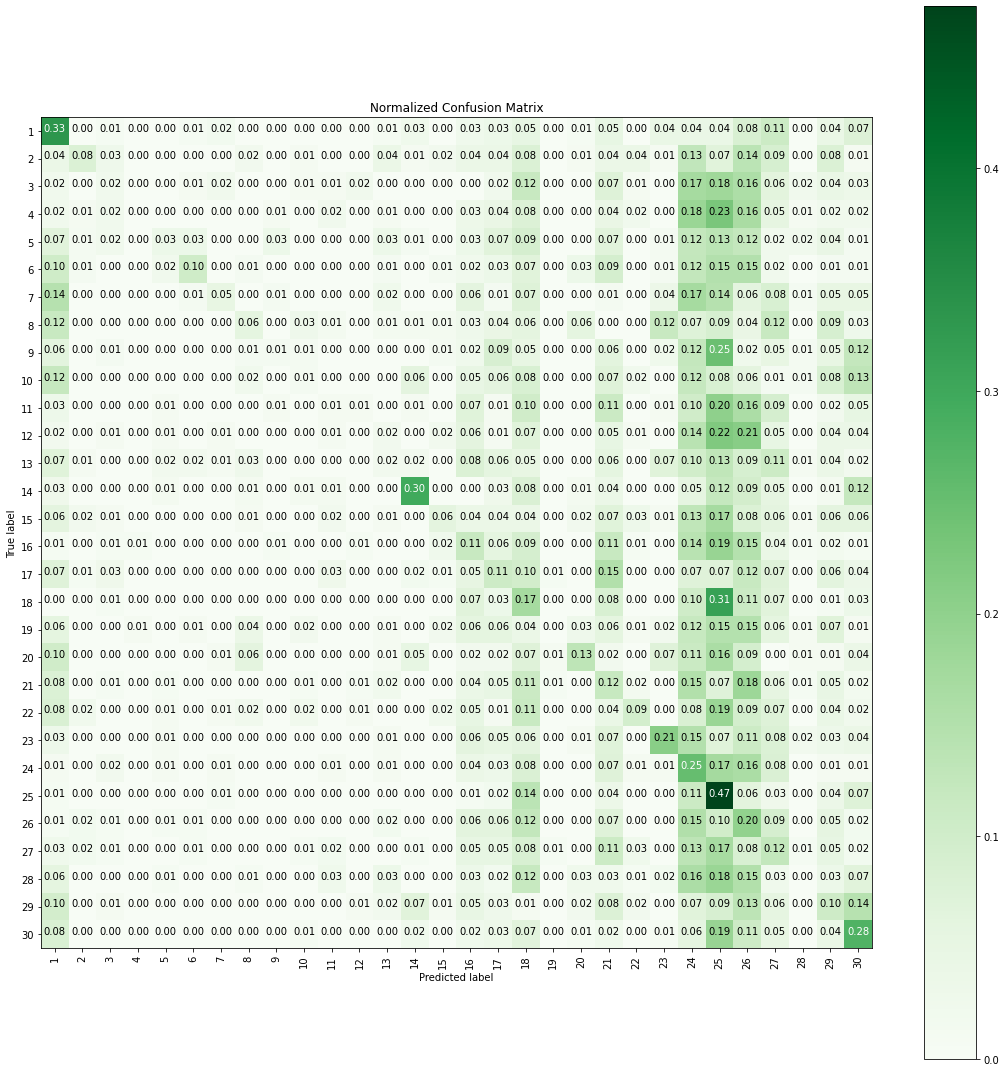


 F1 Score:0.1044736849063878


==> Best Estimator:
	RandomForestClassifier(max_depth=10, n_estimators=160)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 10, 'n_estimators': 160}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.12932324935386175
--------
epsilon:  2.5
--------
training the model...
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Done
==> training time:- 0:06:58.835083

Predicting test data
==> testing time:- 0:00:00.098003

==> Accuracy:- 0.15195274040039383


 ********Confusion Matrix********

 [[46  0  0  0  0  1  1  0  1  2  1  0  1  1  0  4  7  4  0  0  7  0  2  4
   6 10 10  0  9  3]
 [ 4  1  2  2  3  1  0  2  0  3  1  0  0  2  0  3  3  5  1  0  6  2  2 10
   4 24 10  1  6  5]
 [ 4  0  2  0  3  0  2  1  0  1  0  0  3  0  0  0  1 14  0  1  4  1  0  8
  22 13  5  2  8  0]
 [ 0  5  2  6  0  0  0  0  0  0  3  1  1  0  3  4  3  8  0  0  1

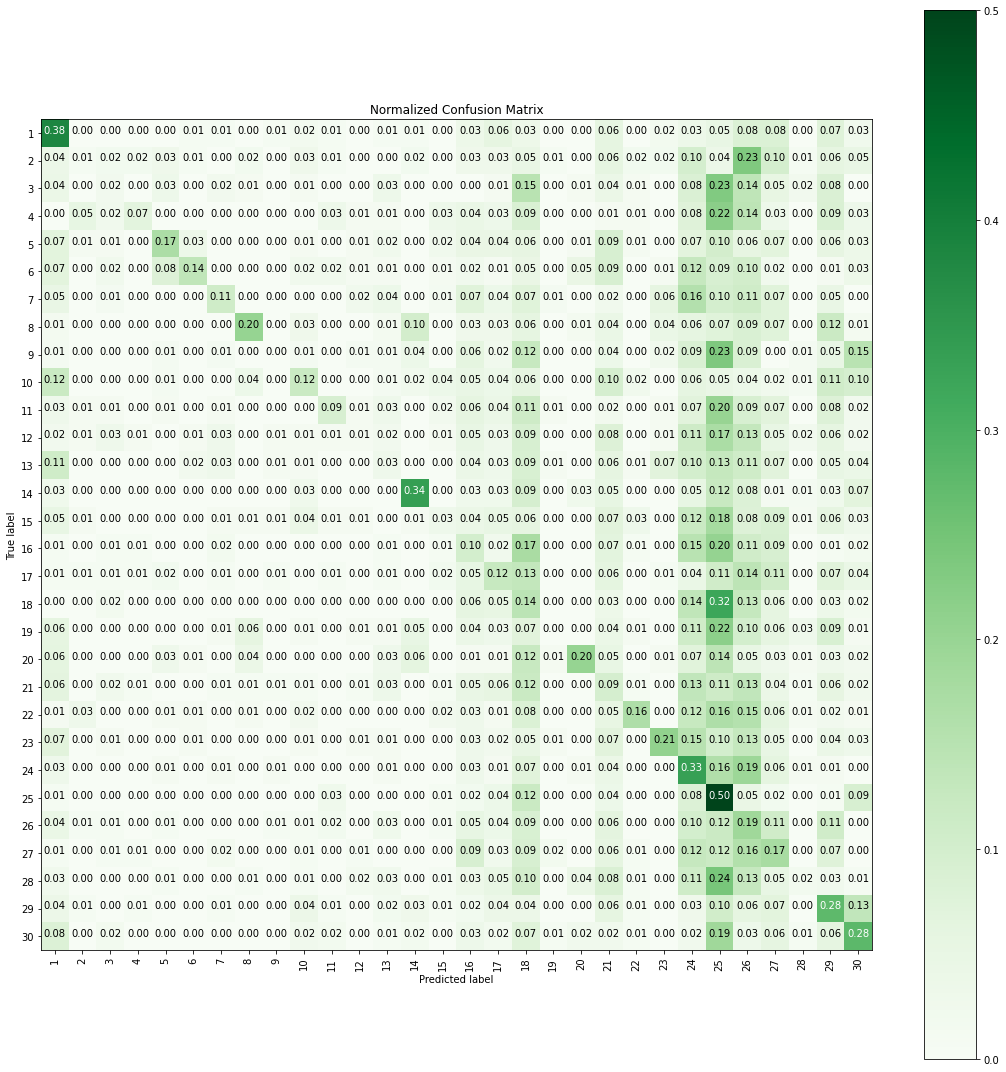


 F1 Score:0.14766399292986257


==> Best Estimator:
	RandomForestClassifier(max_depth=12, n_estimators=180)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 12, 'n_estimators': 180}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.1490469542368255


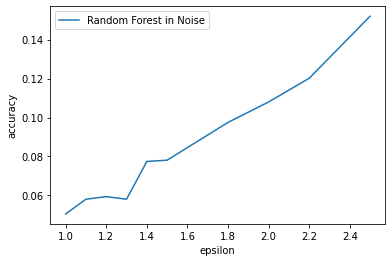

In [34]:
import warnings
# 収束しなかった場合のwarning
from sklearn.exceptions import ConvergenceWarning
# warningを無視する
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=ConvergenceWarning)

# epsilons = [0.01, 0.05, 0.1, 0.3, 0.5, 1.0, 1.5, 2.0, 2.5, 3, 4, 5]
acc_array_random_uid = list()


epsilons = [1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.8, 2.0, 2.2, 2.5]

for epsilon in epsilons:

  print('--------')
  print('epsilon:  '+ str(epsilon))
  print('--------')

  X_train, X_test, y_train, y_test = split_train_test_data(df_concat, 'user_Id')

  for feature in f_add_weighted_noise:
    X_train[feature] = X_train[feature].apply(lambda x: x + np.random.laplace(0, 1.0/weighted_epsilon))
    X_test[feature] = X_test[feature].apply(lambda x: x + np.random.laplace(0, 1.0/weighted_epsilon))

  for col in X_train:
      # default sensitivity = 1.0
    if col not in f_add_weighted_noise:
      X_train[col] = X_train[col].apply(lambda x: x + np.random.laplace(0, 1.0/epsilon))
      X_test[col] = X_test[col].apply(lambda x: x + np.random.laplace(0, 1.0/epsilon))
  
  params = {'n_estimators': np.arange(120,201,20), 'max_depth':np.arange(6,15,2)}
  rfc = RandomForestClassifier()
  rfc_grid = GridSearchCV(rfc, param_grid=params, cv=5, verbose=1, n_jobs=-1)
  rfc_grid_results, f1 = perform_model_epsilon(rfc_grid,  X_train.values, y_train.values, X_test.values, y_test.values, class_labels=labels_uid)
  acc_array_random_uid.append(rfc_grid_results['accuracy'])
  
  # observe the attributes of the model 
  print_grid_search_attributes(rfc_grid_results['model'])
    
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(epsilons[::-1], acc_array_random_uid[::-1], label='Random Forest in Noise')
ax.set_xlabel('epsilon')
ax.set_ylabel('accuracy')
plt.legend(loc='best')
plt.show()


In [35]:
# epsilons = [1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.8, 2.0, 2.2, 2.5]
print(acc_array_random_har)
print(acc_array_random_uid)

[0.4706268460781096, 0.502461437479488, 0.5126353790613718, 0.5352806038726616, 0.5615359369872005, 0.568427961929767, 0.608139153265507, 0.6334099113882508, 0.6563833278634723, 0.6668854611092878]
[0.05054151624548736, 0.058089924515917296, 0.05940269117164424, 0.058089924515917296, 0.07745323268788973, 0.0781096160157532, 0.09747292418772563, 0.10797505743354119, 0.12011814899901542, 0.15195274040039383]


In [36]:
print(weighted_epsilon)

0.001


In [ ]:
def beep():
  from google.colab import output
  output.eval_js('new Audio(\
"https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg")\
.play()')

In [ ]:
# beep()